These experiments were run using two files.

Firstly `continuous.sh` and `train.py`.

Each instance of `train.py` ran a algorithm in a envinronment one time.

To get 10 seeds per environment with 9 envrionments and 3 algorithms there are a total of 270 runs that need to be done.

The 270 runs were completed across two job submissions 1-90 and 91-270.

In [2]:
import os
import math
import numpy as np
import pandas as pd
from itertools import product, chain
import re
import json

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Getting the results

A slight error in the `train.py` code meant that a large chunk of the results had the labels ppo and sac switched, which resulted in the first attempt at the experiments to fail. The result is that the results are split into three different directories from three different grid jobs. Each grid output directory will ony be used to get a single model type from.

## Base line results

In [3]:
trad_algos = [
    ## First set of basic experiments
    "4676490_rl_continuous_control_baseline_experiments", # 1 million timesteps using SB3 td3 with paper hyperparameters. problem with SAC and PPO mislabeled so we ignore the SAC (which are actually PPO results)
    "4676492_rl_continuous_control_baseline_experiments", # 1 million timesteps using SB3 PPO with paper hyperparameters
    "4676867_rl_continuous_control_baseline_experiments", # 1 million timesteps using SB3 SAC with paper hyperparameters

    # Rerunning some experiments with more timesteps as the final performance was not on par with paper: "Policy ensemble gradient for continuous control problems in deep reinforcement learning" baseline experiments
    "4677137_rl_older_env_benchmarks", # 2 million timesteps on ant environment using SB3 SAC to see if it learns better with more timesteps
    "4677138_rl_older_env_benchmarks", # 2 million timesteps with SB3 TD3 on hopper and swimmer 
    "4677139_rl_older_env_benchmarks", # 2 millions steps with SB3 TD3 on Ant
]

# sota_algos = [
#     "4677441_tqc_3mil_test", # 3 million time steps using authors original pytorch code and hyperparameters
#     "4677444_redq_1mil", # 1 milliion timesteps using authors original pytorch code and hyperparameters
#     "4678117_redq_1mil_second_attempt", # Rerunning and GRID engine dropped all the jobs
#     "4678116_tqc_3mil_second_attempt", # Rerunning most as the GRID engines had problems with the jobs. A task id mapper was needed as seen below.
#     "4678133_CrossQ_1mil", # 1 million timesteps using SBX implementation of CrossQ with paper hyperparameters
# ]

# The task id is used by the grid engine to run mulitple jobs each with a different experiemnt e.g envs and logs etc.
# Sometime when expriments  fails they need to be rerun but only a somewhat random subset. So a mapper is made to take the given task id (goes from 1 to n) and map it to the task id of the failed experiment.
task_id_mapper = {
    # sota_algos[3]:  [
    #     6, 7, 8, 10, 11, 12, 14, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 
    #     31, 33, 34, 35, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 53, 54, 57, 58, 
    #     59, 60, 62, 64, 65, 66, 67, 68, 69, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 
    #     88, 89
    # ]
    "2125083_crossq_cont": [
        280, 281, 287, 288, 289, 291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 342, 346, 349, 351, 355, 356, 357, 358
    ],
    "2176907_crossq_cont2": [
        280, 287, 291, 299, 300, 311, 312, 342, 346, 349, 351, 355
    ], # Rerunning as some didnt complete in time. Almost did but just took too long.
    "2183193_crossq_cont3": [
        291, 299, 311, 312
    ],
}

ignore_maps = [
    "2176480_sunrise"
]


grid_output_dir = "/home/thompsjame1/grid-output"
raapoi_output_dir = "/home/thompsjame1/raapoi-output"
results_dirs = [
    os.path.join(grid_output_dir, d) for d in trad_algos
] + [
    os.path.join(raapoi_output_dir, d) for d in os.listdir(raapoi_output_dir) if not any(ignore in d for ignore in ignore_maps)
]

# Map the list so that paths that contains one of the continued jobs are merged into tuples
path_lookup = {
    os.path.basename(p.split('_')[0]): p for p in results_dirs
}

# Some jobs are continued due to not being able to run inside the 10 day limit imposed by the Raapoi cluster.
continued_jobs = [
    # RedQ 1 million split over three job pairs
    (2055760, 2110066), 
    (2055761, 2110067),
    (2055762, 2110068),
]
merged_job_paths = []
paths_included_in_tuples = set()


for job1_id, job2_id in continued_jobs:
    path1 = path_lookup.get(str(job1_id))
    path2 = path_lookup.get(str(job2_id))
    
    if path1 and path2:
        merged_job_paths.append((path1, path2))
        paths_included_in_tuples.add(path1)
        paths_included_in_tuples.add(path2)

# Add remaining paths that were not part of any tuple
remaining_single_paths = [
    p for p in results_dirs if p not in paths_included_in_tuples
]

# Combine the merged tuples and the remaining single paths
results_dirs = merged_job_paths + remaining_single_paths
results_dirs

[('/home/thompsjame1/raapoi-output/2055760_redq_first_500_steps',
  '/home/thompsjame1/raapoi-output/2110066_redq_500_cont'),
 ('/home/thompsjame1/raapoi-output/2055761_redq_first_500_steps',
  '/home/thompsjame1/raapoi-output/2110067_redq_500_cont'),
 ('/home/thompsjame1/raapoi-output/2055762_redq_first_500_steps',
  '/home/thompsjame1/raapoi-output/2110068_redq_500_cont'),
 '/home/thompsjame1/grid-output/4676490_rl_continuous_control_baseline_experiments',
 '/home/thompsjame1/grid-output/4676492_rl_continuous_control_baseline_experiments',
 '/home/thompsjame1/grid-output/4676867_rl_continuous_control_baseline_experiments',
 '/home/thompsjame1/grid-output/4677137_rl_older_env_benchmarks',
 '/home/thompsjame1/grid-output/4677138_rl_older_env_benchmarks',
 '/home/thompsjame1/grid-output/4677139_rl_older_env_benchmarks',
 '/home/thompsjame1/raapoi-output/1985328_droq_1mil',
 '/home/thompsjame1/raapoi-output/1992281_tqc_3mil',
 '/home/thompsjame1/raapoi-output/2001306_crossq_1mil',
 '/hom

The sunrise code outputs in a differnet format. I am using the same output from the authors original implementation.

It is managable as the author provides a progress.csv file for each run that has the returns mean that I need.

In [5]:
def convert_combo_to_number(model, env, seed, total_steps=None, mapper=None):
    """
    Convert a model, env and seed combindation to the task number that is used fro a grid submission
    """

    models = [
        "tqc",
        "redq",
        "ppo",
        "sac",
        "td3",
        "crossq",
        "droq",
    ]

    envs = [
        "HalfCheetah-v5",
        "Walker2d-v5",
        "Humanoid-v5",
        "Ant-v5",
        "HumanoidStandup-v5",
        "Swimmer-v5",
        "Hopper-v5",
        "InvertedDoublePendulum-v5",
        "Pusher-v5",
    ]

    task_id =(0 if models.index(model) < 2 else models.index(model)-2) * 90 + envs.index(env) * 10 + int(seed)

    if mapper is not None:
        task_id = mapper.index(task_id) + 1
    else: 
        task_id = task_id + 1

    return task_id
    
def get_experiment_details(eval_path):
    """
    Take a name of an experiment and get the details from it.
    Assuming the evaluation file is in the format:
    <model>_<env>_<total_steps>_<seed>.npz
    """
    eval_name = eval_path.split('/')[-1]
    model = eval_name.split('_')[0]
    env = eval_name.split('_')[1]
    steps = eval_name.split('_')[2]
    seed = eval_name.split('_')[3].split('.')[0]

    return {
        "model": model,
        "env": env,
        "total_steps": int(float(steps)),
        "seed": seed
    }
    
def get_details(results_dir):
    """
    Take a results direcrtory and get all the experiment details from it.
    """
    if not isinstance(results_dir, tuple):
        results_dir = (results_dir,)

    experiment_details = []

    for results in results_dir:

        evaluation_files = [os.path.join(results, "training_evaluations", f) for f in os.listdir(os.path.join(results, "training_evaluations"))]

        exp_details = list(map(get_experiment_details, evaluation_files))

        mapper = task_id_mapper.get(results.split("/")[-1], None)
        task_numbers = list(map(lambda x: convert_combo_to_number(**x, mapper=mapper), exp_details))

        log_files = [os.path.join(results, "logs", f"{f}_stdout.txt") for f in task_numbers]

        curr_run_details = sorted([
            {
                "evals": evals,
                "logs": logs,
                "details": details,
            }
            for details, logs, evals in zip(exp_details, log_files, evaluation_files)
        ], key=lambda x: re.search(r'/(\d{1,3})_', x['logs']).group(1))

        experiment_details.append(curr_run_details)


    # Merge dicts togather so that each key has a tuple fo values
    experiment_details = [
        {
        k: [d[k] for d in phases]
        for k in phases[0].keys()
        }
        for phases in zip(*experiment_details)
    ]
    return experiment_details

In [6]:
def load_experiments_into_df(result_dirs):
    """
    Load a collection of numpy archive paths into a pandas dataframe.
    It will perform error checking to make sure that all the files are valid and exist as expected.
    It is assumed that the numpy archives have the sample structure with three arrays:
    - 'timesteps': the number of timesteps at evaluations
    - 'results': the rewards at each evaluation
    - 'ep_lengths': the episode lengths at each evaluation
    """
    successful_results, failed_results = [], []

    for experiment in chain.from_iterable(map(get_details, result_dirs)):
        ### Unpacking the evaluation details ###
        try:

            npz = [np.load(path) for path in experiment['evals']]
        except EOFError as e:
            print(f"Failed to load evaluations at {experiment['evals']}: {e}")
            failed_results.append(experiment)
            continue

        evaluation_details = {
            'timesteps': np.concatenate([data['timesteps'] for data in npz]),
            'rewards': np.concatenate([data['results'] for data in npz]),
            'ep_lengths': np.concatenate([data['ep_lengths'] for data in npz]),
            'last_evaluation': max(data['timesteps'][-1] for data in npz),
        }

        ### Unpacking the log details ###

        elapsed_hours = 0.0
        for log_path in experiment['logs']:
            try:
                with open(log_path, 'r') as f:
                    logs = f.readlines()
            except FileNotFoundError as e:
                print(f"Failed to load log at {experiment['logs']}: {e}")
                failed_results.append(experiment)
                continue

            elapsed_seconds = re.search(r"Elapsed seconds: (\d+)", "\n".join(logs))
            if elapsed_seconds is not None:
                elapsed_hours += int(elapsed_seconds.group(1)) / 3600
            else:
                elapsed_hours = None
                break


        ### Adding the details togather ###

        successful_results.append({
            **experiment['details'][-1],
            **evaluation_details,
            "wall_time": elapsed_hours,
        })

    return pd.DataFrame(successful_results), pd.DataFrame(failed_results)

df, failed_df = load_experiments_into_df(results_dirs)
df

Failed to load evaluations at ['/home/thompsjame1/raapoi-output/2055761_redq_first_500_steps/training_evaluations/redq_Humanoid-v5_500000_1.npz', '/home/thompsjame1/raapoi-output/2110067_redq_500_cont/training_evaluations/redq_Humanoid-v5_1000000_1.npz']: No data left in file
Failed to load evaluations at ['/home/thompsjame1/raapoi-output/2055761_redq_first_500_steps/training_evaluations/redq_Humanoid-v5_500000_4.npz', '/home/thompsjame1/raapoi-output/2110067_redq_500_cont/training_evaluations/redq_Humanoid-v5_1000000_4.npz']: No data left in file
Failed to load evaluations at ['/home/thompsjame1/raapoi-output/2055761_redq_first_500_steps/training_evaluations/redq_Humanoid-v5_500000_5.npz', '/home/thompsjame1/raapoi-output/2110067_redq_500_cont/training_evaluations/redq_Humanoid-v5_1000000_5.npz']: No data left in file
Failed to load evaluations at ['/home/thompsjame1/raapoi-output/2055761_redq_first_500_steps/training_evaluations/redq_Humanoid-v5_500000_7.npz', '/home/thompsjame1/raap

,model,env,total_steps,seed,timesteps,rewards,ep_lengths,last_evaluation,wall_time
0,redq,HalfCheetah-v5,1000000,0,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[7.850122738925848, 1.7635371879939756, 5.302...","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",1000000,226.086944
1,redq,HalfCheetah-v5,1000000,9,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-4.285600623333681, -2.9975696320689167, -1....","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",1000000,171.210000
2,redq,Walker2d-v5,1000000,0,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-2.6124363503240033, -2.670060308908514, -2....","[[13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13...",1000000,170.616389
3,redq,Walker2d-v5,1000000,1,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[2.156823330129814, -9.50392978600705, -3.984...","[[109.0, 100.0, 105.0, 108.0, 111.0, 105.0, 10...",1000000,223.984722
4,redq,Walker2d-v5,1000000,2,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[75.58498895645779, 84.3995679822401, 87.5021...","[[143.0, 144.0, 174.0, 119.0, 108.0, 70.0, 111...",1000000,228.444444
...,...,...,...,...,...,...,...,...,...
872,redq,HumanoidStandup-v5,1000000,7,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[98097.3835751109, 96841.70800778006, 54149.8...","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",629000,0.000000
873,redq,HumanoidStandup-v5,1000000,9,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[47982.67190058436, 78161.13590160423, 81805....","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",737000,0.000000
874,redq,Swimmer-v5,1000000,0,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[18.22673233157667, 25.675458372076253, 22.28...","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",972000,0.000000
875,redq,Pusher-v5,1000000,4,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-887.4590939904482, -887.1866219153611, -866...","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",1000000,0.000000


In [13]:
# Find duplicate env, algo and seed combos

duplicates = df[df.duplicated(subset=['model', 'env', 'seed'], keep=False)]

# Only keep the ones with the duplicated with the highest total_steps
duplicates = duplicates.sort_values('last_evaluation', ascending=False)
duplicates = duplicates.drop_duplicates(subset=['model', 'env', 'seed'], keep='first')
duplicates

# Drop duplicates from the original dataframe
df = df.sort_values('last_evaluation', ascending=False).drop_duplicates(subset=['model', 'env', 'seed'], keep='first')
# Reseort by index
df = df.sort_index()
df

,model,env,total_steps,seed,timesteps,rewards,ep_lengths,last_evaluation,wall_time
0,redq,HalfCheetah-v5,1000000,0,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[7.850122738925848, 1.7635371879939756, 5.302...","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",1000000,226.086944
1,redq,HalfCheetah-v5,1000000,9,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-4.285600623333681, -2.9975696320689167, -1....","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",1000000,171.210000
2,redq,Walker2d-v5,1000000,0,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-2.6124363503240033, -2.670060308908514, -2....","[[13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13...",1000000,170.616389
3,redq,Walker2d-v5,1000000,1,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[2.156823330129814, -9.50392978600705, -3.984...","[[109.0, 100.0, 105.0, 108.0, 111.0, 105.0, 10...",1000000,223.984722
6,redq,Walker2d-v5,1000000,4,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-0.2141132303951625, -0.029237724914347396, ...","[[14.0, 13.0, 13.0, 13.0, 13.0, 13.0, 14.0, 14...",1000000,198.137222
...,...,...,...,...,...,...,...,...,...
866,redq,Humanoid-v5,1000000,5,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[65.03460214088027, 64.43206400211001, 65.123...","[[15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15.0, 15...",783000,0.000000
870,redq,HumanoidStandup-v5,1000000,5,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[79042.99773276785, 62732.21751602508, 79885....","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",638000,0.000000
871,redq,HumanoidStandup-v5,1000000,6,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[44337.1422172756, 45472.767240462555, 53670....","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",625000,0.000000
873,redq,HumanoidStandup-v5,1000000,9,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[47982.67190058436, 78161.13590160423, 81805....","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",737000,0.000000


## Sunrise and extensions


In [39]:
def process_sunrise_run(dir):
    """
    Process the results from a single run of the sunrise experiment.
    """

    variant = json.load(open(os.path.join(dir, "variant.json"), "r"))

    full_progress = pd.read_csv(os.path.join(dir, "progress.csv")).rename(columns={"replay_buffer/size": "timesteps", "evaluation/Returns Mean": "mean_rewards", "time/epoch (s)": "duration"})

    results = full_progress[["timesteps", "mean_rewards", "duration"]]
    
    results["model"] = "sunrise"

    results["env"] = variant["env"]
    results["seed"] = variant["seed"]

    return results

def get_sunrise_results(path):
    """
    Parse the results from a batch sunrise experiment output directory.
    """

    # Get each individual run directories.

    run_dirs = [os.path.join(path, d) for d in os.listdir(path) if d != "logs"]

    experiment_details = [
        process_sunrise_run(run_dir) for run_dir in run_dirs
    ]

    return pd.concat(experiment_details, ignore_index=True)

sunrise_baseline_results = get_sunrise_results(os.path.join(raapoi_output_dir, ignore_maps[0]))
sunrise_baseline_results


/tmp/ipykernel_2249758/3628625139.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["model"] = "sunrise"
/tmp/ipykernel_2249758/3628625139.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  results["env"] = variant["env"]
/tmp/ipykernel_2249758/3628625139.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

,timesteps,mean_rewards,duration,model,env,seed
0,2000,-21.214710,208.248238,sunrise,Swimmer-v5,7
1,3000,20.692929,218.518909,sunrise,Swimmer-v5,7
2,4000,30.321964,217.799055,sunrise,Swimmer-v5,7
3,5000,45.198209,218.884278,sunrise,Swimmer-v5,7
4,6000,27.461786,218.783396,sunrise,Swimmer-v5,7
...,...,...,...,...,...,...
89995,997000,45.774513,211.017421,sunrise,Swimmer-v5,1
89996,998000,43.794065,211.173255,sunrise,Swimmer-v5,1
89997,999000,44.382845,211.497182,sunrise,Swimmer-v5,1
89998,1000000,44.831413,211.429534,sunrise,Swimmer-v5,1


In [66]:
sunrise_mean_rewards = sunrise_baseline_results.groupby(["env", "model", "timesteps"]).agg(
    mean_rewards=("mean_rewards", "mean"),
    upper_ci=("mean_rewards", lambda x: np.percentile(x, 85)),
    lower_ci=("mean_rewards", lambda x: np.percentile(x, 15))
).reset_index()

sunrise_mean_rewards

,env,model,timesteps,mean_rewards,upper_ci,lower_ci
0,Ant-v5,sunrise,2000,994.009990,1000.372565,988.941512
1,Ant-v5,sunrise,3000,952.470720,969.012299,934.276437
2,Ant-v5,sunrise,4000,511.007419,846.493349,129.727389
3,Ant-v5,sunrise,5000,366.382932,601.494893,118.638703
4,Ant-v5,sunrise,6000,299.892570,461.806072,67.744943
...,...,...,...,...,...,...
8986,Walker2d-v5,sunrise,996000,4661.768366,5186.047987,4305.124105
8987,Walker2d-v5,sunrise,997000,4634.402009,5145.480684,4289.685727
8988,Walker2d-v5,sunrise,998000,4654.656131,5160.800801,4231.054634
8989,Walker2d-v5,sunrise,999000,4647.218923,4936.222462,4363.329173


In [88]:
sunrise_times = sunrise_baseline_results.groupby(["env", "model", 'timesteps']).agg({
    "duration": "mean",
}).reset_index()

sunrise_times["wall_clock"] = sunrise_times["duration"].apply(lambda x: x / 3600)  # Convert seconds to hours

sunrise_times["wall_time_approx_steps"] = sunrise_times.groupby(["model", "env"])['wall_clock'].cumsum()

sunrise_times.drop(columns=['duration', 'wall_clock'], inplace=True)

sunrise_times = sunrise_times.merge(sunrise_mean_rewards, on=["env", "model", "timesteps"], how="left")

sunrise_times = sunrise_times.groupby(["env", "model"]).agg({
    "mean_rewards": lambda x: list(x),
    "upper_ci": lambda x: list(x),
    "lower_ci": lambda x: list(x),
    "wall_time_approx_steps": lambda x: list(x)
}).reset_index()

sunrise_times

,env,model,mean_rewards,upper_ci,lower_ci,wall_time_approx_steps
0,Ant-v5,sunrise,"[994.0099902651067, 952.4707196317001, 511.007...","[1000.3725650321021, 969.0122988156262, 846.49...","[988.9415120842892, 934.2764370951516, 129.727...","[0.06764797558182747, 0.13804507704231783, 0.2..."
1,HalfCheetah-v5,sunrise,"[-0.3679124945646185, -9.817973710479189, -14....","[0.058976742292489226, -4.520247016036432, -10...","[-0.6310803373031735, -17.516033199014363, -19...","[0.059433522886260304, 0.1228709224672574, 0.1..."
2,Hopper-v5,sunrise,"[140.27937496456212, 80.61499427674957, 74.558...","[156.65103757776603, 84.86272800814636, 128.71...","[122.73687295326395, 63.22721662752312, 45.551...","[0.05624718996758262, 0.11650260356254875, 0.1..."
3,Humanoid-v5,sunrise,"[218.59184686634325, 160.96916219053205, 302.4...","[240.8034873294494, 197.24060810518407, 366.60...","[185.2641856587919, 103.71631084837452, 215.79...","[0.0944201010466398, 0.1892304795500822, 0.283..."
4,HumanoidStandup-v5,sunrise,"[29141.842620143485, 39091.77173581023, 52985....","[29763.933204866007, 40012.828717542194, 75436...","[28581.43141054118, 31966.175952038826, 34172....","[0.07400410077702771, 0.15189708943796965, 0.2..."
5,InvertedDoublePendulum-v5,sunrise,"[86.21737813958457, 112.27172134832051, 137.04...","[88.37792408058547, 117.8539300514777, 145.060...","[84.39498485532474, 106.29500380230405, 126.26...","[0.06655337528426511, 0.13619483014441924, 0.2..."
6,Pusher-v5,sunrise,"[-54.74911450347827, -52.159584661286985, -61....","[-52.63003754847318, -46.64959347412499, -54.8...","[-56.641470004380466, -58.01931681952784, -67....","[0.05771986919569058, 0.11717122166176946, 0.1..."
7,Swimmer-v5,sunrise,"[1.0002361161569504, 22.633096841762057, 33.59...","[18.71333782395977, 33.110920827714786, 40.532...","[-19.42546651609141, 15.72912725402347, 28.351...","[0.056635684120960324, 0.11653631404254378, 0...."
8,Walker2d-v5,sunrise,"[101.98235879639944, 16.25505642390661, 297.20...","[125.21587240117479, 39.48171791625201, 331.10...","[82.3854524954499, -3.769217347393894, 281.405...","[0.07491734819339277, 0.1512396994364034, 0.22..."


# Validating the results

I would like to validate two things abotu the results.

1. That the model types are actually waht they say they are.
2. That the correct number of runs and seeds have been run

In [16]:
## Check to see if the amount of runs matches the expected time steps.
df_removed_uncompleted = df[1_000_000 <= df['last_evaluation']]

df_removed_uncompleted

,model,env,total_steps,seed,timesteps,rewards,ep_lengths,last_evaluation,wall_time
0,redq,HalfCheetah-v5,1000000,0,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[7.850122738925848, 1.7635371879939756, 5.302...","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",1000000,226.086944
1,redq,HalfCheetah-v5,1000000,9,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-4.285600623333681, -2.9975696320689167, -1....","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",1000000,171.210000
2,redq,Walker2d-v5,1000000,0,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-2.6124363503240033, -2.670060308908514, -2....","[[13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13...",1000000,170.616389
3,redq,Walker2d-v5,1000000,1,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[2.156823330129814, -9.50392978600705, -3.984...","[[109.0, 100.0, 105.0, 108.0, 111.0, 105.0, 10...",1000000,223.984722
6,redq,Walker2d-v5,1000000,4,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-0.2141132303951625, -0.029237724914347396, ...","[[14.0, 13.0, 13.0, 13.0, 13.0, 13.0, 14.0, 14...",1000000,198.137222
...,...,...,...,...,...,...,...,...,...
794,crossq,Ant-v5,1000000,9,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[23.080529, -21.794908, 12.787694, 252.821398...","[[77, 1000, 123, 1000, 1000, 1000, 1000, 1000,...",1000000,215.656111
807,redq,Hopper-v5,1000000,2,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[28.02623282097207, 29.5187358351672, 29.2353...","[[45.0, 47.0, 47.0, 46.0, 48.0, 46.0, 46.0, 47...",1000000,234.981111
823,redq,InvertedDoublePendulum-v5,1000000,8,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[73.05619051509908, 100.90225509804553, 109.9...","[[9.0, 12.0, 13.0, 13.0, 10.0, 11.0, 14.0, 12....",1000000,234.490556
825,redq,Pusher-v5,1000000,0,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-745.0661355048558, -702.082237695127, -596....","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",1000000,239.857500


## Make sure that the correct number of experiemnts per model env pair are made

Each environment and model pair needs to be run 10 times. Due to running this on a grid-solar system there is not guarentees that the experiment will complete.

In [17]:
# Count number of seeds per model and env
counts_per_group = df_removed_uncompleted.groupby(['model', 'env']).count()
counts_per_group[counts_per_group['seed'] < 10]

total_steps  seed  timesteps  rewards  \
model  env                                                                
crossq HalfCheetah-v5                       9     9          9        9   
       Humanoid-v5                          8     8          8        8   
       HumanoidStandup-v5                   9     9          9        9   
       InvertedDoublePendulum-v5            7     7          7        7   
       Pusher-v5                            8     8          8        8   
       Walker2d-v5                          9     9          9        9   
redq   Humanoid-v5                          5     5          5        5   
       HumanoidStandup-v5                   5     5          5        5   
       Pusher-v5                            8     8          8        8   

                                  ep_lengths  last_evaluation  wall_time  
model  env                                                                
crossq HalfCheetah-v5                      9                9          9  
       Humanoid-v5                         8                8          8  
       HumanoidStandup-v5                  9                9          9  
       InvertedDoublePendulum-v5           7                7          7  
       Pusher-v5                           8                8          8  
       Walker2d-v5                         9                9          9  
redq   Humanoid-v5                         5                5          3  
       HumanoidStandup-v5                  5                5          5  
       Pusher-v5                           8                8          8

In [10]:
def get_missing_runs(df):
    """
    Get the environment model and seed combindations that are missing from the dataframe
    """
    models = df['model'].unique()
    envs = df['env'].unique()
    seeds = df['seed'].unique()

    expected_combinations = list(product(models, envs, seeds))
    print(f"Expected combinations: {expected_combinations}")

    completed_combinations = [tuple(comb) for comb in df[['model', 'env', 'seed']].values.tolist()]
    print(f"Completed combinations: {completed_combinations}")

    missing_combinations = [comb for comb in expected_combinations if comb not in completed_combinations]

    return missing_combinations

missing_combinations = get_missing_runs(df_removed_uncompleted)
len(missing_combinations), missing_combinations

Expected combinations: [('redq', 'HalfCheetah-v5', '0'), ('redq', 'HalfCheetah-v5', '9'), ('redq', 'HalfCheetah-v5', '1'), ('redq', 'HalfCheetah-v5', '4'), ('redq', 'HalfCheetah-v5', '5'), ('redq', 'HalfCheetah-v5', '6'), ('redq', 'HalfCheetah-v5', '7'), ('redq', 'HalfCheetah-v5', '8'), ('redq', 'HalfCheetah-v5', '2'), ('redq', 'HalfCheetah-v5', '3'), ('redq', 'Walker2d-v5', '0'), ('redq', 'Walker2d-v5', '9'), ('redq', 'Walker2d-v5', '1'), ('redq', 'Walker2d-v5', '4'), ('redq', 'Walker2d-v5', '5'), ('redq', 'Walker2d-v5', '6'), ('redq', 'Walker2d-v5', '7'), ('redq', 'Walker2d-v5', '8'), ('redq', 'Walker2d-v5', '2'), ('redq', 'Walker2d-v5', '3'), ('redq', 'Humanoid-v5', '0'), ('redq', 'Humanoid-v5', '9'), ('redq', 'Humanoid-v5', '1'), ('redq', 'Humanoid-v5', '4'), ('redq', 'Humanoid-v5', '5'), ('redq', 'Humanoid-v5', '6'), ('redq', 'Humanoid-v5', '7'), ('redq', 'Humanoid-v5', '8'), ('redq', 'Humanoid-v5', '2'), ('redq', 'Humanoid-v5', '3'), ('redq', 'Ant-v5', '0'), ('redq', 'Ant-v5', '9

(22,
 [('redq', 'Humanoid-v5', '9'),
  ('redq', 'Humanoid-v5', '1'),
  ('redq', 'Humanoid-v5', '4'),
  ('redq', 'Humanoid-v5', '5'),
  ('redq', 'Humanoid-v5', '7'),
  ('redq', 'HumanoidStandup-v5', '9'),
  ('redq', 'HumanoidStandup-v5', '4'),
  ('redq', 'HumanoidStandup-v5', '5'),
  ('redq', 'HumanoidStandup-v5', '6'),
  ('redq', 'HumanoidStandup-v5', '8'),
  ('redq', 'Pusher-v5', '7'),
  ('redq', 'Pusher-v5', '3'),
  ('crossq', 'HalfCheetah-v5', '9'),
  ('crossq', 'Walker2d-v5', '6'),
  ('crossq', 'Humanoid-v5', '0'),
  ('crossq', 'Humanoid-v5', '8'),
  ('crossq', 'HumanoidStandup-v5', '0'),
  ('crossq', 'InvertedDoublePendulum-v5', '1'),
  ('crossq', 'InvertedDoublePendulum-v5', '5'),
  ('crossq', 'InvertedDoublePendulum-v5', '8'),
  ('crossq', 'Pusher-v5', '0'),
  ('crossq', 'Pusher-v5', '4')])

In [21]:
missing_nums = [convert_combo_to_number(*combo)- 1 for combo in missing_combinations if combo[0] == "redq"]
missing_nums.sort()
len(missing_nums), " ".join([str(num) for num in missing_nums])

(12, '21 24 25 27 29 44 45 46 48 49 83 87')

# Visualizing the results

## Learning curves

In [25]:
df_grouped = df.explode(['timesteps', 'rewards']).groupby(['model', 'env', 'timesteps']).agg({
    "rewards": lambda x: np.vstack(x),
}).reset_index()
df_grouped

,model,env,timesteps,rewards
0,crossq,Ant-v5,1000,"[[292.72498, 41.178029, 258.822321, 140.682441..."
1,crossq,Ant-v5,2000,"[[43.648335, 455.816983, -1.72525, 354.845997,..."
2,crossq,Ant-v5,3000,"[[83.104219, 77.950178, 166.993668, 274.042629..."
3,crossq,Ant-v5,4000,"[[470.199574, 2.837676, 157.700232, 136.726176..."
4,crossq,Ant-v5,5000,"[[-5.247493, 8.478058, 475.082938, 2.389183, 8..."
...,...,...,...,...
76332,tqc,Walker2d-v5,2721000,"[[6150.428538070454, 6132.002656011417, 6192.5..."
76333,tqc,Walker2d-v5,2722000,"[[6190.0531598136495, 6242.402433336779, 6141...."
76334,tqc,Walker2d-v5,2723000,"[[6125.27816983444, 6156.890909820354, 3084.47..."
76335,tqc,Walker2d-v5,2724000,"[[6196.5620910945145, 6194.654199246402, 6216...."


In [26]:
sunrise_baseline_results['upper_ci'] = sunrise_baseline_results['mean_rewards']
sunrise_baseline_results['lower_ci'] = sunrise_baseline_results['mean_rewards']

In [ ]:
def add_mean_ci(df, ci, axis=None): 
    df["mean_rewards"] = df["rewards"].apply(lambda x: np.mean(x, axis=axis))
    df['upper_ci'] = df['rewards'].apply(lambda x: np.percentile(x, ci, axis=axis))
    df['lower_ci'] = df['rewards'].apply(lambda x: np.percentile(x, 100-ci, axis=axis))
    return df

df_grouped = add_mean_ci(df_grouped, 85)


df_grouped = pd.concat([df_grouped, sunrise_mean_rewards], ignore_index=True)
df_grouped

,model,env,timesteps,rewards,mean_rewards,upper_ci,lower_ci,duration,seed
0,crossq,Ant-v5,1000,"[[292.72498, 41.178029, 258.822321, 140.682441...",289.025483,487.061509,72.163587,NaN,NaN
1,crossq,Ant-v5,2000,"[[43.648335, 455.816983, -1.72525, 354.845997,...",162.493129,495.719281,-38.109216,NaN,NaN
2,crossq,Ant-v5,3000,"[[83.104219, 77.950178, 166.993668, 274.042629...",229.094697,548.079308,2.642992,NaN,NaN
3,crossq,Ant-v5,4000,"[[470.199574, 2.837676, 157.700232, 136.726176...",310.535081,618.439740,15.122094,NaN,NaN
4,crossq,Ant-v5,5000,"[[-5.247493, 8.478058, 475.082938, 2.389183, 8...",300.228253,609.372208,34.415178,NaN,NaN
...,...,...,...,...,...,...,...,...,...
175323,sunrise,Walker2d-v5,996000,NaN,4661.768366,NaN,NaN,NaN,NaN
175324,sunrise,Walker2d-v5,997000,NaN,4634.402009,NaN,NaN,NaN,NaN
175325,sunrise,Walker2d-v5,998000,NaN,4654.656131,NaN,NaN,NaN,NaN
175326,sunrise,Walker2d-v5,999000,NaN,4647.218923,NaN,NaN,NaN,NaN


In [36]:
from scipy.signal import savgol_filter

# Add a smoothing function using Savitzky-Golay
def smooth_savgol(data, window_size=50, polyorder=2):
    # Ensure the window size is smaller than the data length
    if len(data) < window_size:
        window_size = len(data) if len(data) % 2 == 1 else len(data) - 1  # Ensure window size is odd
    return savgol_filter(data, window_size, polyorder)

# Apply smoothing to each group
def apply_smoothing(group):
    group = group.sort_values("timesteps")  # Ensure data is sorted by x-axis (env_steps)
    group["smoothed_mean_rewards"] = smooth_savgol(group["mean_rewards"])
    group["smoothed_upper_ci"] = smooth_savgol(group["upper_ci"])
    group["smoothed_lower_ci"] = smooth_savgol(group["lower_ci"])
    return group

# Group by model, algo, and env, and apply smoothing
df_smoothed = df_grouped.groupby(["model", "env"]).apply(apply_smoothing)

df_smoothed

/tmp/ipykernel_2249758/758811617.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_smoothed = df_grouped.groupby(["model", "env"]).apply(apply_smoothing)


model          env  timesteps  \
model  env                                                 
crossq Ant-v5      0      crossq       Ant-v5       1000   
                   1      crossq       Ant-v5       2000   
                   2      crossq       Ant-v5       3000   
                   3      crossq       Ant-v5       4000   
                   4      crossq       Ant-v5       5000   
...                          ...          ...        ...   
tqc    Walker2d-v5 76332     tqc  Walker2d-v5    2721000   
                   76333     tqc  Walker2d-v5    2722000   
                   76334     tqc  Walker2d-v5    2723000   
                   76335     tqc  Walker2d-v5    2724000   
                   76336     tqc  Walker2d-v5    2725000   

                                                                    rewards  \
model  env                                                                    
crossq Ant-v5      0      [[292.72498, 41.178029, 258.822321, 140.682441...   
                   1      [[43.648335, 455.816983, -1.72525, 354.845997,...   
                   2      [[83.104219, 77.950178, 166.993668, 274.042629...   
                   3      [[470.199574, 2.837676, 157.700232, 136.726176...   
                   4      [[-5.247493, 8.478058, 475.082938, 2.389183, 8...   
...                                                                     ...   
tqc    Walker2d-v5 76332  [[6150.428538070454, 6132.002656011417, 6192.5...   
                   76333  [[6190.0531598136495, 6242.402433336779, 6141....   
                   76334  [[6125.27816983444, 6156.890909820354, 3084.47...   
                   76335  [[6196.5620910945145, 6194.654199246402, 6216....   
                   76336  [[6228.3470756560255, 6177.308518976192, 6157....   

                          mean_rewards     upper_ci     lower_ci  duration  \
model  env                                                                   
crossq Ant-v5      0        289.025483   487.061509    72.163587       NaN   
                   1        162.493129   495.719281   -38.109216       NaN   
                   2        229.094697   548.079308     2.642992       NaN   
                   3        310.535081   618.439740    15.122094       NaN   
                   4        300.228253   609.372208    34.415178       NaN   
...                                ...          ...          ...       ...   
tqc    Walker2d-v5 76332   6151.982952  6183.904582  6127.738622       NaN   
                   76333   5867.100971  6204.903696  6146.783871       NaN   
                   76334   5134.303660  6166.101131  3336.359235       NaN   
                   76335   6184.701260  6210.160852  6155.784407       NaN   
                   76336   6167.720730  6181.739965  6139.511853       NaN   

                          seed  smoothed_mean_rewards  smoothed_upper_ci  \
model  env                                                                 
crossq Ant-v5      0       NaN             198.033802         501.865204   
                   1       NaN             205.812233         510.228009   
                   2       NaN             214.172940         519.748708   
                   3       NaN             223.115922         530.427299   
                   4       NaN             232.641181         542.263784   
...                        ...                    ...                ...   
tqc    Walker2d-v5 76332   NaN            6009.708808        6391.310523   
                   76333   NaN            5991.576167        6354.488676   
                   76334   NaN            5973.003934        6316.387317   
                   76335   NaN            5953.992107        6277.006445   
                   76336   NaN            5934.540687        6236.346061   

                          smoothed_lower_ci  
model  env                                   
crossq Ant-v5      0              11.741088  
                   1              11.399476  
                   2          

In [37]:
def make_multi_plot(
        df,
        x_name,
        y_name,
        y_upper_name = "upper_ci",
        y_lower_name = "lower_ci",
        x_label = "Time steps",
        y_label = "Average Reward",
        envs = 'all',
        add_hline = False,
        envs_vline = None,
        save_name = None):
    """
    Makes a plot with multiple environments with multiple models in each envinronment.
    For each line it will add in the mean and the confidence intervals.
    Assumes that column models and envs are in the dataframe everything else is given.
    """
    if envs == 'all':
        envs = df['env'].unique()
    cols = 3
    rows = math.ceil(len(envs) / cols)

    unique_models = df['model'].unique()
    color_map = {
        model: plt.cm.tab10(i) for i, model in enumerate(unique_models)
    }

    # Create subplots
    fig, axes = plt.subplots(rows, cols, figsize=(cols*5, (rows*3) + 1))
    axes = axes.flatten()

    line_handles = []
    line_labels = []

    for i, env in enumerate(envs):
        ax = axes[i]
        # Filter data for the current environment
        env_data = df[df["env"] == env]

        # Plot mean rewards
        for model in env_data["model"].unique():
            model_data = env_data[env_data["model"] == model]
            if len(model_data) == 1:
                model_data = model_data.iloc[0]
            
            line,  =ax.plot(
                model_data[x_name],
                model_data[y_name],
                label=model,
                alpha=0.7,
                linewidth=2,
                color=color_map[model],
            )

            # Plot confidence intervals
            ax.fill_between(
                model_data[x_name],
                model_data[y_lower_name],
                model_data[y_upper_name],
                alpha=0.2,
                color=line.get_color(),
            )


            if add_hline:
                # Add a horizontal bar at the height of the final mean reward
                final_mean_reward = model_data[y_name][-1]
                final_wall_clock = model_data[x_name][-1]
                
                final_wall_clock_axes = ax.transData.transform((final_wall_clock, 0))[0]  # Transform to display coordinates
                final_wall_clock_axes = ax.transAxes.inverted().transform((final_wall_clock_axes, 0))[0]  # Transform 
                ax.axhline(
                    xmin=final_wall_clock_axes,
                    y=final_mean_reward,
                    color=line.get_color(),
                    linestyle="--",
                    linewidth=1,
                    label=f"{model} final {y_label}",
                )

            
            if model not in line_labels:
                print(f"Adding {model} to legend")
                line_handles.append(line)
                line_labels.append(model)

        if envs_vline is not None:
            ax.axvline(
                x=envs_vline[env],
                color='black',
                linestyle='--',
                linewidth=2,
                alpha=0.6,
                zorder=0,
                label=f"real {env} time",
            )

        ax.set_title(f'{env}')
        if i % cols == 0:  # Only show y-axis label on the first column
            ax.set_ylabel(y_label)
        if (i >= (rows - 1) * cols) or ((len(envs)-i) <= cols):  # Only show x-axis label on the last row or if there are no more graphs directly bleow it 
            ax.set_xlabel(x_label)
        ax.grid(True)
    
    if envs_vline is not None:
        vline_legend = Line2D([0], [0], color='red', linestyle='--', linewidth=1, label="Environment time (vline)")
        line_handles.append(vline_legend)
        line_labels.append("Environment time (vline)")

    for j in range(len(envs), len(axes)):
        fig.delaxes(axes[j])

    # Add legend
    fig.legend(
        handles=line_handles,
        labels=line_labels,
        loc="upper center",
        bbox_to_anchor=(0.5, 0), 
        ncol=len(line_labels),
        fontsize=16,
    )

    if save_name is not None:
        fig.savefig(
            os.path.join('..', 'figures', f"{save_name}"),
            bbox_inches='tight',
            dpi=300,
        )

    return fig

Adding crossq to legend
Adding droq to legend
Adding ppo to legend
Adding redq to legend
Adding sac to legend
Adding sunrise to legend
Adding td3 to legend
Adding tqc to legend


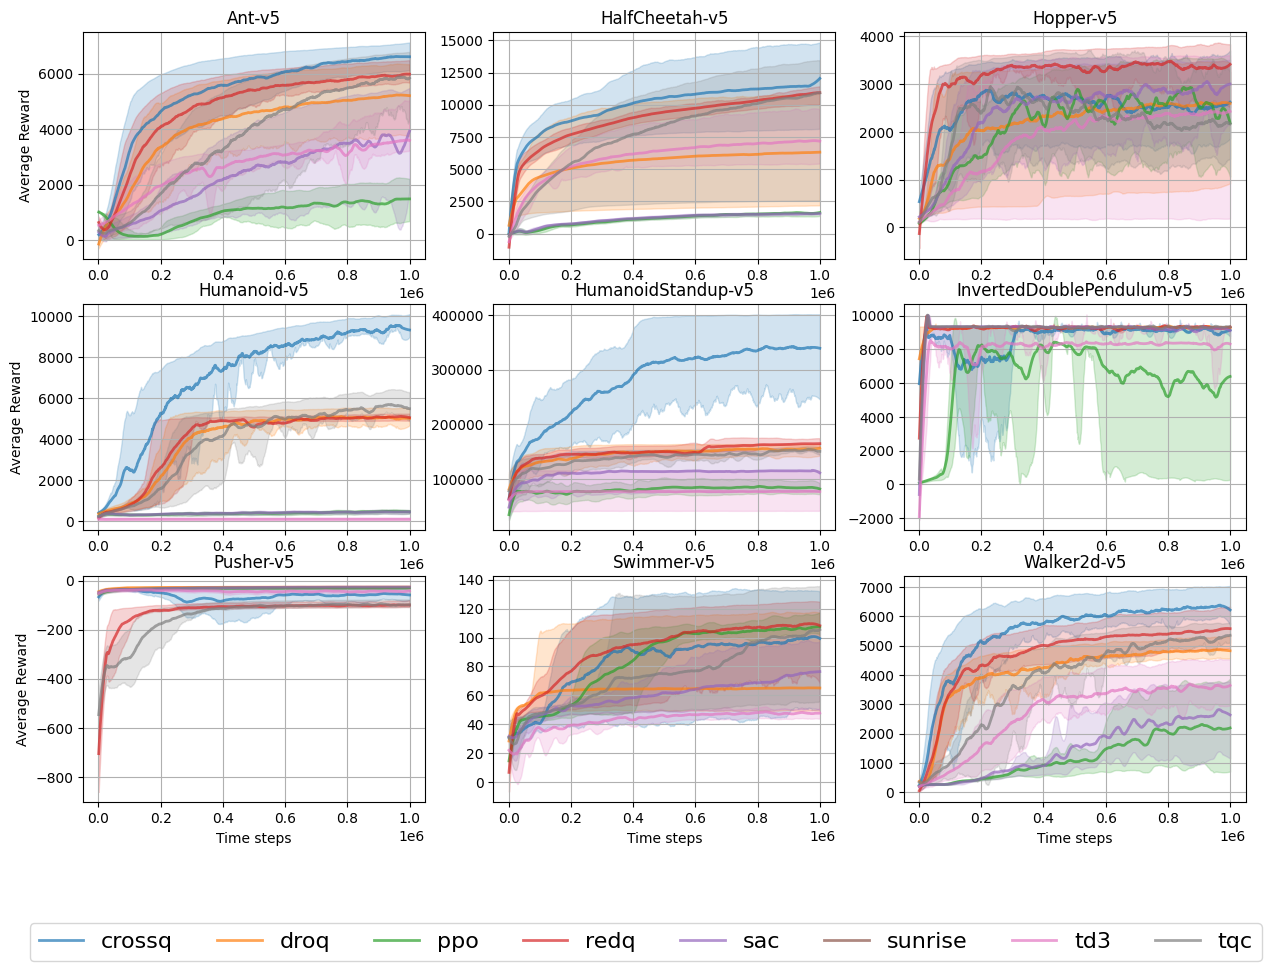

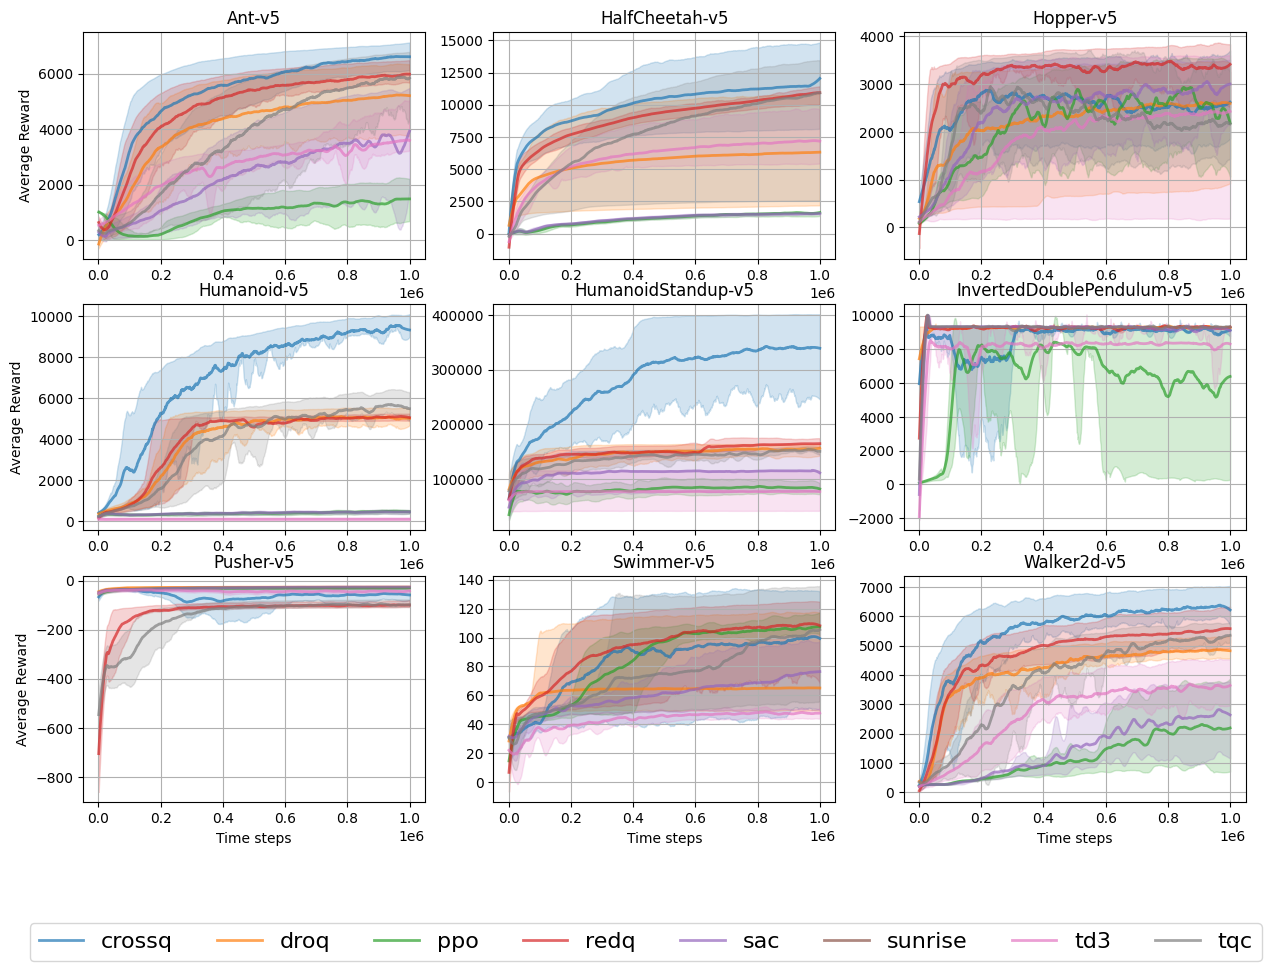

In [38]:
plot_df = df_smoothed[df_smoothed['timesteps'] <= 1_000_000]

plot_df[plot_df['model']=='sunrise']

make_multi_plot(
    plot_df,
    x_name='timesteps',
    y_name='smoothed_mean_rewards',
    y_upper_name='smoothed_upper_ci',
    y_lower_name='smoothed_lower_ci',
    save_name="baseline_results",
)

### Comparing to PEG paper results

For these becnhmarks it is important that we get similar results to other papers.

In [114]:
PEG = {
    "td3": {
        "hopper": 3200,
        "swimmer": 57,
        "walker2d": 3700,
        "humanoid": 200,
        "ant": 4300,
        "humanoidstandup": 82000
    },
    "sac": {
        "hopper": 3200,
        "swimmer": 42,
        "walker2d": 4500,
        "humanoid": 5200,
        "ant": 5200,
        "humanoidstandup": 140000
    }
}

mine = {
    "td3": {
        "halfcheetah": 7000,
        "walker2d": 3500,
        "humanoid": 200,
        "ant": 3000,
        "humanoidstandup": 80000,
        "swimmer": 48,
        "hopper": 2600,
        "inverteddoublependulum": 8200,
        "pusher": -50
    },
    "sac": {
        "halfcheetah": 7000,
        "walker2d": 4500,
        "humanoid": 5000,
        "ant": 4200,
        "humanoidstandup": 140000,
        "swimmer": 80,
        "hopper": 3000,
        "inverteddoublependulum": 8200,
        "pusher": -30
    },
    "ppo": {
        "halfcheetah": 1800,
        "walker2d": 2100,
        "humanoid": 500,
        "ant": 1800,
        "humanoidstandup": 82500,
        "swimmer": 110,
        "hopper": 2500,
        "inverteddoublependulum": 600,
        "pusher": -30
    }
}



In [115]:
percentage_threshold = 10  # Adjust this value as needed (e.g., 20% difference)
def compare_results_with_percentage(other, mine, percentage_threshold):
    significant_differences = {}
    
    for algo in other:
        if algo in mine:
            for env, peg_value in other[algo].items():
                if env in mine[algo]:
                    mine_value = mine[algo][env]
                    if peg_value != 0:  # Avoid division by zero
                        percentage_diff = (peg_value - mine_value) / abs(peg_value) * 100
                        if percentage_diff > percentage_threshold:
                            if algo not in significant_differences:
                                significant_differences[algo] = {}
                            significant_differences[algo][env] = {
                                "PEG": peg_value,
                                "mine": mine_value,
                                "percentage_difference": percentage_diff
                            }
    return significant_differences

# Compare PEG and mine
significant_differences = compare_results_with_percentage(PEG, mine, percentage_threshold)

# Print the results
for algo, envs in significant_differences.items():
    print(f"Algorithm: {algo}")
    for env, values in envs.items():
        print(f"  Environment: {env}")
        print(f"    PEG paper Value: {values['PEG']}")
        print(f"    My hyperparameter Value: {values['mine']}")
        print(f"    Percentage Difference: {values['percentage_difference']:.2f}%")

Algorithm: td3
  Environment: hopper
    PEG paper Value: 3200
    My hyperparameter Value: 2600
    Percentage Difference: 18.75%
  Environment: swimmer
    PEG paper Value: 57
    My hyperparameter Value: 48
    Percentage Difference: 15.79%
  Environment: ant
    PEG paper Value: 4300
    My hyperparameter Value: 3000
    Percentage Difference: 30.23%
Algorithm: sac
  Environment: ant
    PEG paper Value: 5200
    My hyperparameter Value: 4200
    Percentage Difference: 19.23%


## Wall clock time

### Understanding environment time

In [72]:
import gymnasium as gym

def get_env_time(envs, length):
    envs_dt = [gym.make(env).env.unwrapped.dt for env in envs]
    envs_time_for_length = [(dt * length) / 3600 for dt in envs_dt]

    return {
        env: round(time, 2)
        for env, time in zip(envs, envs_time_for_length)
    } 

envs_time = get_env_time(df['env'].unique(), 1_000_000)

### Making plot

In [73]:
def cut_to_length(df, length=1_000_000):
    """
    Cut the dataframe experiemtns data to length
    """
    df = df.copy().dropna(subset=['wall_time'])

    num_evals = length // 1_000

    df['timesteps'] = df['timesteps'].apply(lambda x: x[x <= length])
    df['rewards'] = df['rewards'].apply(lambda x: x[:num_evals])
    df['ep_lengths'] = df['ep_lengths'].apply(lambda x: x[:num_evals])

    df['time_to_length'] = df['wall_time'] / df['last_evaluation'] * length
    df['wall_time_approx_steps'] = df['time_to_length'].apply(lambda x: np.linspace(0, x, num_evals))
    df.drop("last_evaluation", axis=1, inplace=True)

    return df

wall_clock_measurements = cut_to_length(df_removed_uncompleted)
wall_clock_measurements

,model,env,total_steps,seed,timesteps,rewards,ep_lengths,wall_time,time_to_length,wall_time_approx_steps
0,redq,HalfCheetah-v5,1000000,0,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[7.850122738925848, 1.7635371879939756, 5.302...","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",226.086944,226.086944,"[0.0, 0.22631325770214658, 0.45262651540429316..."
1,redq,HalfCheetah-v5,1000000,9,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-4.285600623333681, -2.9975696320689167, -1....","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",171.210000,171.210000,"[0.0, 0.17138138138138137, 0.34276276276276274..."
2,redq,Walker2d-v5,1000000,0,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-2.6124363503240033, -2.670060308908514, -2....","[[13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13.0, 13...",170.616389,170.616389,"[0.0, 0.17078717606495383, 0.34157435212990767..."
3,redq,Walker2d-v5,1000000,1,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[2.156823330129814, -9.50392978600705, -3.984...","[[109.0, 100.0, 105.0, 108.0, 111.0, 105.0, 10...",223.984722,223.984722,"[0.0, 0.2242089311533756, 0.4484178623067512, ..."
6,redq,Walker2d-v5,1000000,4,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-0.2141132303951625, -0.029237724914347396, ...","[[14.0, 13.0, 13.0, 13.0, 13.0, 13.0, 14.0, 14...",198.137222,198.137222,"[0.0, 0.19833555778000223, 0.39667111556000445..."
...,...,...,...,...,...,...,...,...,...,...
794,crossq,Ant-v5,1000000,9,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[23.080529, -21.794908, 12.787694, 252.821398...","[[77, 1000, 123, 1000, 1000, 1000, 1000, 1000,...",215.656111,215.656111,"[0.0, 0.2158719830942053, 0.4317439661884106, ..."
807,redq,Hopper-v5,1000000,2,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[28.02623282097207, 29.5187358351672, 29.2353...","[[45.0, 47.0, 47.0, 46.0, 48.0, 46.0, 46.0, 47...",234.981111,234.981111,"[0.0, 0.23521632743854967, 0.47043265487709934..."
823,redq,InvertedDoublePendulum-v5,1000000,8,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[73.05619051509908, 100.90225509804553, 109.9...","[[9.0, 12.0, 13.0, 13.0, 10.0, 11.0, 14.0, 12....",234.490556,234.490556,"[0.0, 0.23472528083639194, 0.4694505616727839,..."
825,redq,Pusher-v5,1000000,0,"[1000, 2000, 3000, 4000, 5000, 6000, 7000, 800...","[[-745.0661355048558, -702.082237695127, -596....","[[1000.0, 1000.0, 1000.0, 1000.0, 1000.0, 1000...",239.857500,239.857500,"[0.0, 0.24009759759759758, 0.48019519519519516..."


In [74]:
merged_wall_clock_measurements = wall_clock_measurements.groupby(["model", "env"]).agg({
    'rewards': lambda x: [0] + np.hstack(x),
    'time_to_length': lambda x: np.mean(x),
    'wall_time_approx_steps': lambda x: x.iloc[0],
}).reset_index()

merged_wall_clock_measurements

,model,env,rewards,time_to_length,wall_time_approx_steps
0,crossq,Ant-v5,"[[292.72498, 41.178029, 258.822321, 140.682441...",210.562889,"[0.0, 0.1586403069736403, 0.3172806139472806, ..."
1,crossq,HalfCheetah-v5,"[[-61.915249, -62.627785, -63.421522, -64.0639...",209.567407,"[0.0, 0.23506812367923477, 0.47013624735846954..."
2,crossq,Hopper-v5,"[[999.863489, 1000.223313, 999.589827, 999.470...",184.939694,"[0.0, 0.19273328884439997, 0.38546657768879994..."
3,crossq,Humanoid-v5,"[[596.007612, 468.968858, 446.234816, 483.1924...",194.748542,"[0.0, 0.20250722945167388, 0.40501445890334775..."
4,crossq,HumanoidStandup-v5,"[[53598.530551, 27110.987602, 57273.862267, 50...",200.545525,"[0.0, 0.23789901012123232, 0.47579802024246465..."
5,crossq,InvertedDoublePendulum-v5,"[[174.266371, 212.726075, 380.354771, 277.3070...",221.882659,"[0.0, 0.2103928928928929, 0.4207857857857858, ..."
6,crossq,Pusher-v5,"[[-94.486822, -81.782318, -98.852574, -95.2127...",201.070347,"[0.0, 0.1977416305194083, 0.3954832610388166, ..."
7,crossq,Swimmer-v5,"[[33.044392, 25.864082, 34.783305, 21.015031, ...",192.835639,"[0.0, 0.2248000778556334, 0.4496001557112668, ..."
8,crossq,Walker2d-v5,"[[-17.310161, -17.224517, -17.945745, -18.0766...",189.139568,"[0.0, 0.209428317206095, 0.41885663441219, 0.6..."
9,droq,Ant-v5,"[[363.187697, -579.3457, 361.981554, 381.84228...",124.729750,"[0.0, 0.12456817929040151, 0.24913635858080302..."


In [75]:
merged_wall_clock_measurements = add_mean_ci(merged_wall_clock_measurements, 85, 1)
merged_wall_clock_measurements

,model,env,rewards,time_to_length,wall_time_approx_steps,mean_rewards,upper_ci,lower_ci
0,crossq,Ant-v5,"[[292.72498, 41.178029, 258.822321, 140.682441...",210.562889,"[0.0, 0.1586403069736403, 0.3172806139472806, ...","[289.02548277000005, 162.49312896, 229.0946973...","[487.06150905, 495.71928115, 548.0793081999999...","[72.1635871, -38.109215750000004, 2.6429920499..."
1,crossq,HalfCheetah-v5,"[[-61.915249, -62.627785, -63.421522, -64.0639...",209.567407,"[0.0, 0.23506812367923477, 0.47013624735846954...","[-66.51694937777778, -43.502841922222224, 132....","[1.6309418499999877, -10.6122272, 342.91326304...","[-304.2705973, -62.1197613, -15.84806565, -13...."
2,crossq,Hopper-v5,"[[999.863489, 1000.223313, 999.589827, 999.470...",184.939694,"[0.0, 0.19273328884439997, 0.38546657768879994...","[724.58081859, 765.91611691, 640.3528682, 631....","[1033.05995, 1014.29648495, 1011.80250055, 101...","[19.7405701, 247.81849964999998, 185.12513295,..."
3,crossq,Humanoid-v5,"[[596.007612, 468.968858, 446.234816, 483.1924...",194.748542,"[0.0, 0.20250722945167388, 0.40501445890334775...","[271.31485935, 332.343556575, 405.390422337500...","[355.77255554999994, 399.72050189999993, 475.6...","[182.01521785, 276.6291009, 331.00884379999997..."
4,crossq,HumanoidStandup-v5,"[[53598.530551, 27110.987602, 57273.862267, 50...",200.545525,"[0.0, 0.23789901012123232, 0.47579802024246465...","[44461.95696924444, 48342.157282122214, 66293....","[61888.710299799954, 63250.511126449994, 80434...","[30057.02732885, 29880.3724548, 45064.46271215..."
5,crossq,InvertedDoublePendulum-v5,"[[174.266371, 212.726075, 380.354771, 277.3070...",221.882659,"[0.0, 0.2103928928928929, 0.4207857857857858, ...","[287.85751639999995, 495.9989730571428, 5801.6...","[396.30691555, 709.7659261499999, 9359.5355628...","[187.29126, 296.24583845, 614.96646675, 9355.6..."
6,crossq,Pusher-v5,"[[-94.486822, -81.782318, -98.852574, -95.2127...",201.070347,"[0.0, 0.1977416305194083, 0.3954832610388166, ...","[-89.49325033750002, -71.5137797375, -61.30578...","[-61.618798950000006, -50.093342850000006, -46...","[-108.8742956, -74.17711685, -77.1174688000000..."
7,crossq,Swimmer-v5,"[[33.044392, 25.864082, 34.783305, 21.015031, ...",192.835639,"[0.0, 0.2248000778556334, 0.4496001557112668, ...","[20.21312312, 24.576484420000007, 28.313245110...","[41.063735799999996, 42.264964049999996, 41.46...","[-5.154963800000001, 8.98481915, 13.8513746499..."
8,crossq,Walker2d-v5,"[[-17.310161, -17.224517, -17.945745, -18.0766...",189.139568,"[0.0, 0.209428317206095, 0.41885663441219, 0.6...","[278.71291771111106, 214.77600692222222, 313.0...","[617.98609375, 391.68446815, 582.1988268, 439....","[-16.8030534, 8.833201049999996, 52.2328244499..."
9,droq,Ant-v5,"[[363.187697, -579.3457, 361.981554, 381.84228...",124.729750,"[0.0, 0.12456817929040151, 0.24913635858080302...","[-5.214290509999999, -188.74728076, -123.41722...","[252.25777044999995, -6.626684800000007, 14.55...","[-117.1775331, -544.8216718, -421.96019205, -4..."


Adding crossq to legend
Adding droq to legend
Adding redq to legend
Adding sunrise to legend


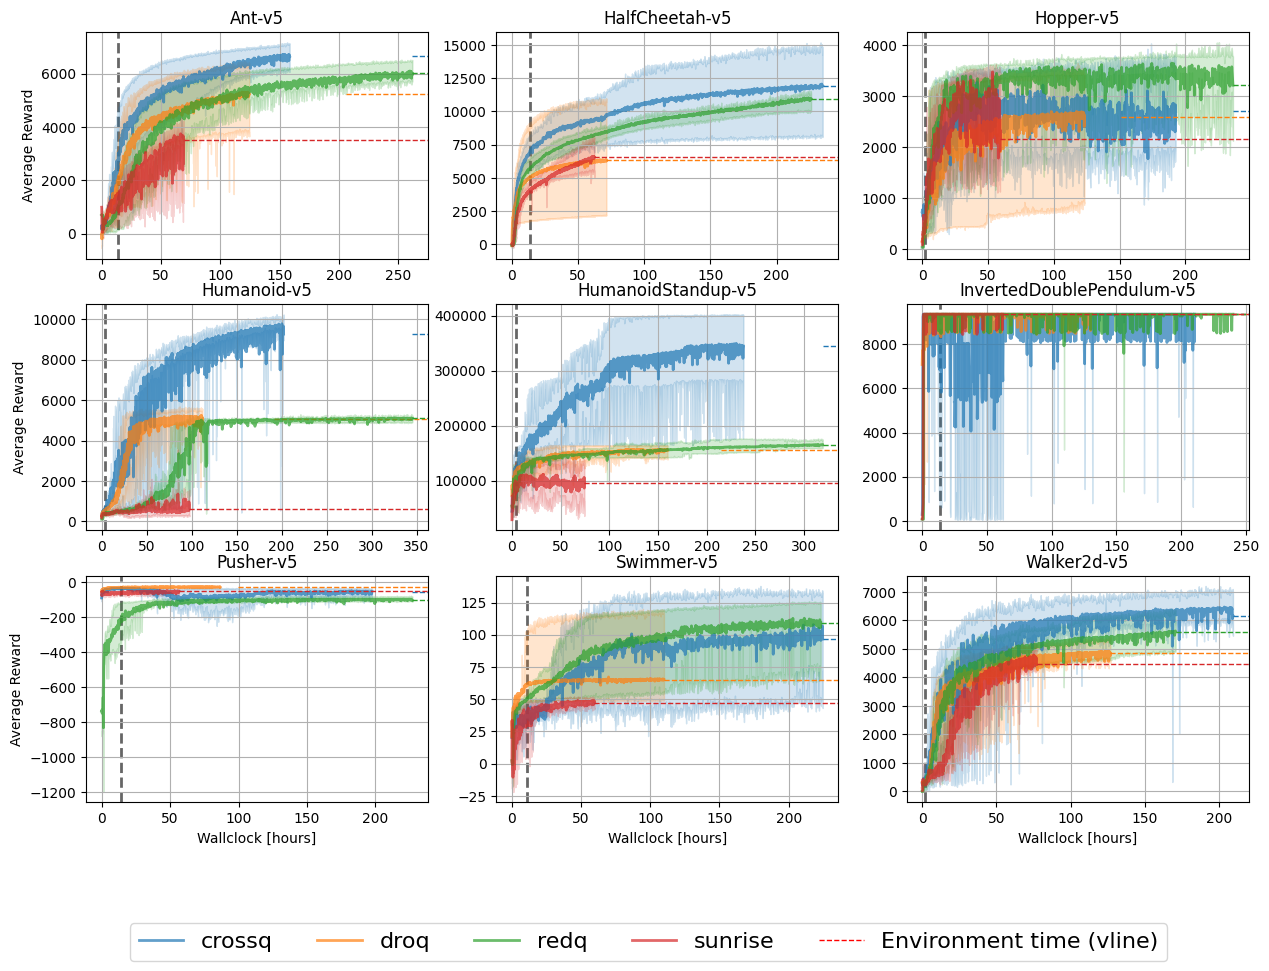

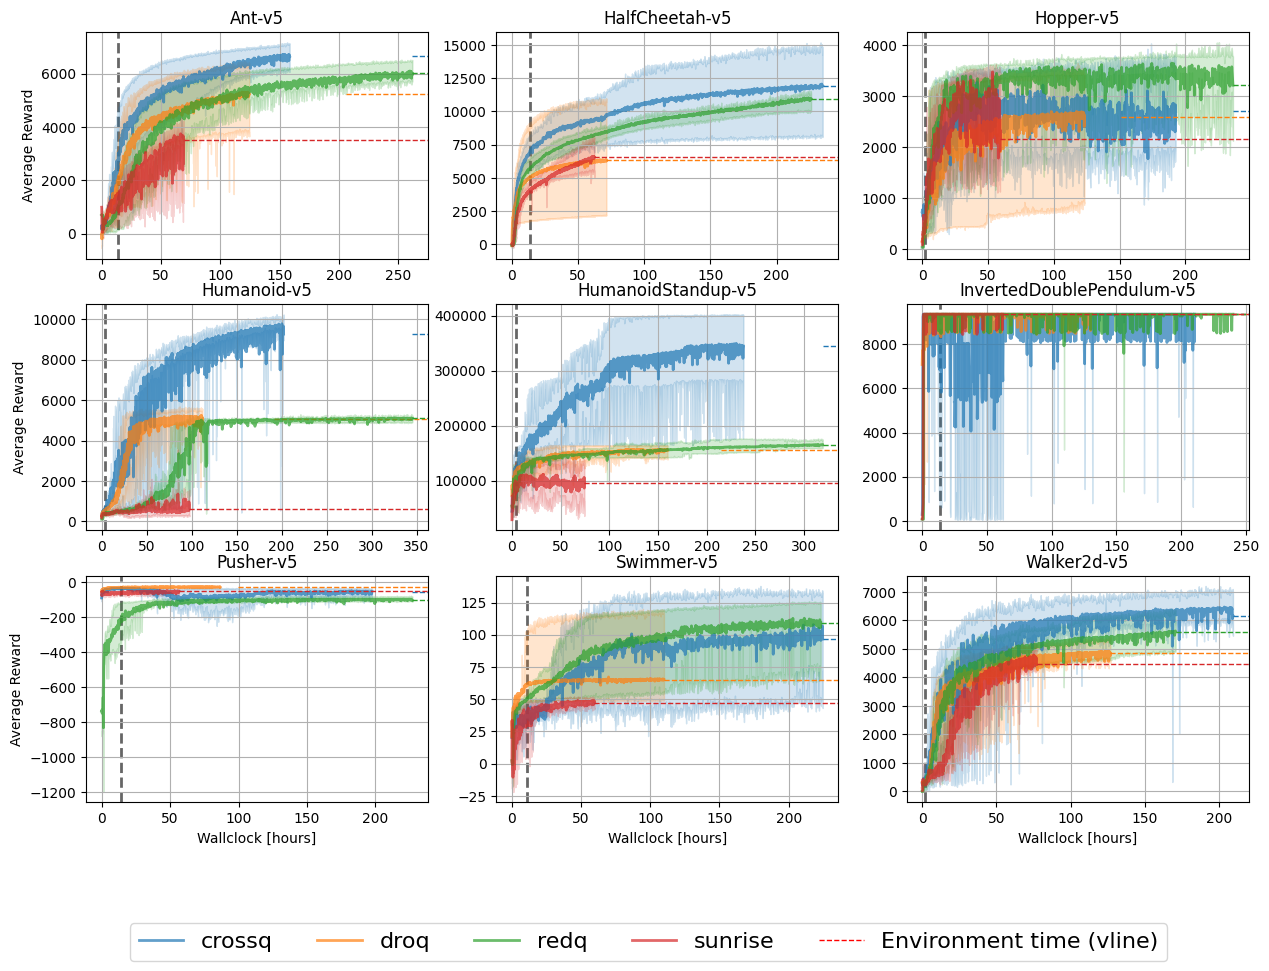

In [90]:
plot_df = pd.concat([merged_wall_clock_measurements.query("model != 'tqc'"), sunrise_times], ignore_index=True)


make_multi_plot(
    plot_df,
    x_name='wall_time_approx_steps',
    y_name='mean_rewards',
    y_upper_name='upper_ci',
    y_lower_name='lower_ci',
    x_label='Wallclock [hours]',
    add_hline=True,
    envs_vline=envs_time,
    save_name="wall_clock_results",
)

## Cluster tracking

I am just interested in the usage of the diffeent clusters that I have.


### Raapoi tracking

In [40]:
raapoi = pd.read_csv("/home/thompsjame1/cluster_tracking/raapoi_cpu_usage.csv")
raapoi['Timestamp'] = pd.to_datetime(raapoi['Timestamp'].map(lambda x: x.replace("NZST ", "")), format='%a %b %d %H:%M:%S %Y')
raapoi['allocated_percentage'] = raapoi['Allocated'] / raapoi['Total'] * 100
raapoi['used_percentage'] = raapoi['MemUsed_GiB'] / raapoi['MemTotal_GiB'] * 100
raapoi

,Partition,Nodes,Allocated,Idle,Other,Total,MemUsed_GiB,MemFree_GiB,MemTotal_GiB,Timestamp,allocated_percentage,used_percentage
0,quicktest,4,0,1024,0,1024,107.31,1904.37,2011.68,2025-04-18 10:44:12,0.000000,5.334347
1,bigmem,4,64,448,0,512,77.67,3950.01,4027.68,2025-04-18 10:44:12,12.500000,1.928405
2,parallel,25,2188,3060,1024,6272,3276.67,8541.43,11818.10,2025-04-18 10:44:12,34.885204,27.725861
3,gpu,3,66,702,0,768,173.42,1335.33,1508.75,2025-04-18 10:44:12,8.593750,11.494283
4,longrun,2,164,348,0,512,360.24,645.60,1005.84,2025-04-18 10:44:12,32.031250,35.814841
...,...,...,...,...,...,...,...,...,...,...,...,...
10140,quicktest,4,64,960,0,1024,62.93,1948.75,2011.68,2025-06-02 15:30:01,6.250000,3.128231
10141,bigmem,4,292,220,0,512,923.67,3104.01,4027.68,2025-06-02 15:30:01,57.031250,22.933053
10142,parallel,25,1114,3878,1280,6272,1424.91,10393.19,11818.10,2025-06-02 15:30:01,17.761480,12.057014
10143,gpu,3,40,728,0,768,55.08,1453.67,1508.75,2025-06-02 15:30:01,5.208333,3.650704


(array([20200., 20209., 20216., 20223., 20230., 20240.]),
 [Text(20200.0, 0, '2025-04-22'),
  Text(20209.0, 0, '2025-05-01'),
  Text(20216.0, 0, '2025-05-08'),
  Text(20223.0, 0, '2025-05-15'),
  Text(20230.0, 0, '2025-05-22'),
  Text(20240.0, 0, '2025-06-01')])

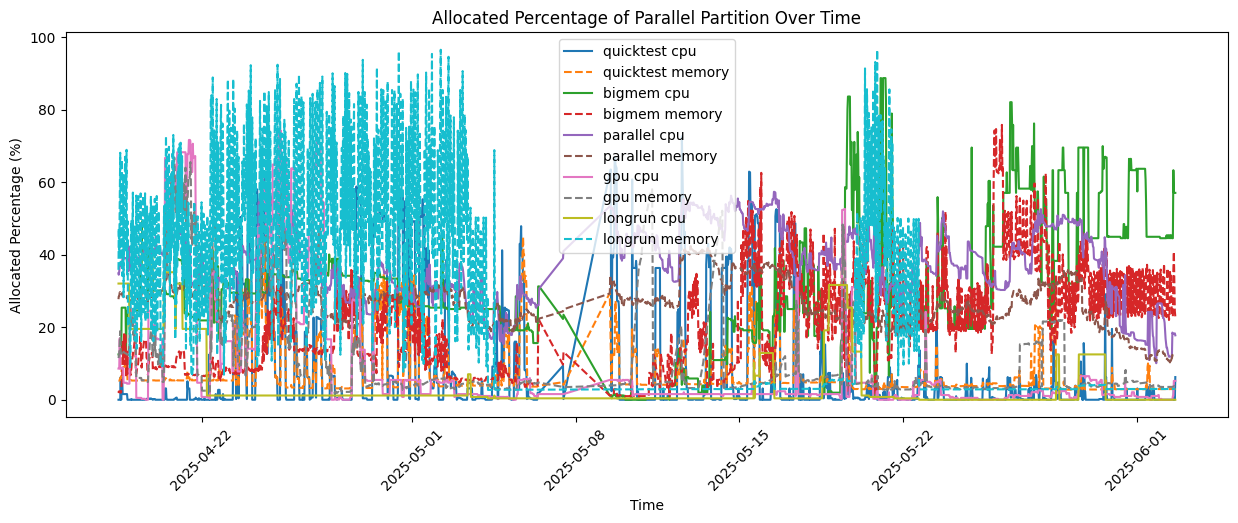

In [41]:
# PLot of allocated percentage of parallel parition over time

plt.figure(figsize=(15, 5))
# Differnet line for each partition
partitions = raapoi['Partition'].unique()
for partition in partitions:
    partition_data = raapoi[raapoi['Partition'] == partition]
    plt.plot(partition_data['Timestamp'], partition_data['allocated_percentage'], label=f"{partition} cpu")
    plt.plot(partition_data['Timestamp'], partition_data['used_percentage'], linestyle='--', label=f"{partition} memory")
plt.legend()
plt.title('Allocated Percentage of Parallel Partition Over Time')
plt.xlabel('Time')
plt.ylabel('Allocated Percentage (%)')
plt.xticks(rotation=45)


### ECS tracking

Here I will track how many jobs i have running on the ecs grid

In [42]:
ecs = pd.read_csv("/home/thompsjame1/cluster_tracking/ecs_grid_my_running_job_usage.csv")
ecs

,Timestamp,Running,Transferring,QueuedJobs
0,2025-04-16 11:15:00,8,24,"CrossQ_1mi,293-360:1;"
1,2025-04-16 11:20:00,9,23,"CrossQ_1mi,293-360:1;"
2,2025-04-16 12:00:00,8,24,"CrossQ_1mi,294-360:1;"
3,2025-04-16 13:00:00,6,26,"CrossQ_1mi,294-360:1;"
4,2025-04-16 14:00:00,8,24,"CrossQ_1mi,295-360:1;"
...,...,...,...,...
1130,2025-06-02 12:00:00,0,6,NaN
1131,2025-06-02 13:00:00,0,6,NaN
1132,2025-06-02 14:00:00,0,6,NaN
1133,2025-06-02 15:00:00,0,6,NaN


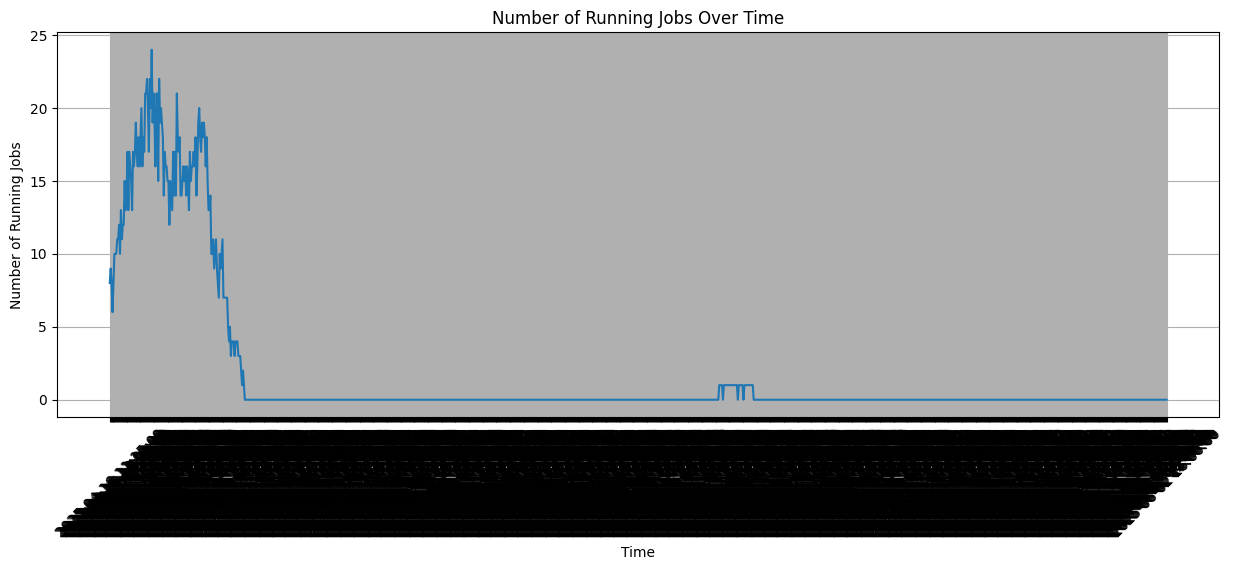

In [43]:
# Plot number of running jobs
plt.figure(figsize=(15, 5))
plt.plot(ecs['Timestamp'], ecs['Running'])
plt.title('Number of Running Jobs Over Time')
plt.xlabel('Time')
plt.ylabel('Number of Running Jobs')
plt.xticks(rotation=45)
plt.grid()